In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

from sklearn.base import RegressorMixin
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

Сгенерим $100$ датасетов по $50$ наблюдений в каждом. $x$ будем брать равномерно из $[0, 2]$. $y$ получим как

$$y = x^3 - 2x^2 + x + \varepsilon, \quad \varepsilon \sim \mathcal N(0, 0.04)$$

In [2]:
sample_size = 50
samples_cnt = 100
N = int(sample_size * samples_cnt)

def f(x: np.array,
      noise_std: float) -> np.array:
    y = x ** 3 - 2 * x ** 2 + x
    noise = np.random.normal(size=x.shape, scale=noise_std)
    y += noise
    return y

X_all = np.random.uniform(low=0, high=2, size=(samples_cnt, sample_size))
y_all = f(X_all, noise_std=0.2)

x_linspace = np.linspace(0, 2, 50)
y_linspace = f(x_linspace, noise_std=0)

Истинная зависимость имеет вид:

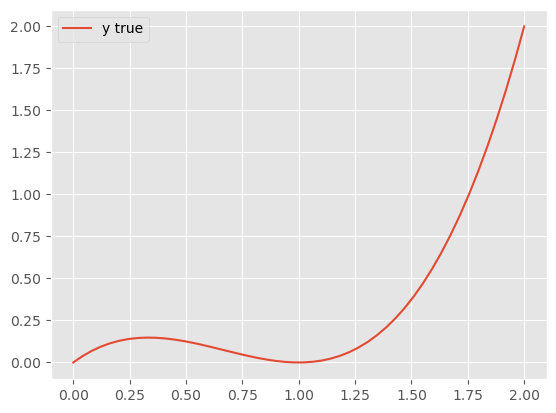

In [3]:
plt.plot(x_linspace, y_linspace, label="y true")
plt.legend();

Визуализируем предсказания моделей на отдельных датасетах из нашего набора:

In [4]:
def plot_predictions(
        X: np.array,
        y: np.array,
        model: RegressorMixin
    ) -> None:
    """Обучает модель model на датасете (X, y) и отрисовывает датасет и
    предсказания модели."""
    model = model.fit(X.reshape(-1, 1), y)
    preds = model.predict(x_linspace.reshape(-1, 1))

    plt.plot(x_linspace, preds, color="C1")
    plt.plot(X, y, '.', color="C3")
    plt.xlim(-0.1, 2.08)
    plt.ylim(-0.55, 2.21)
    plt.show()

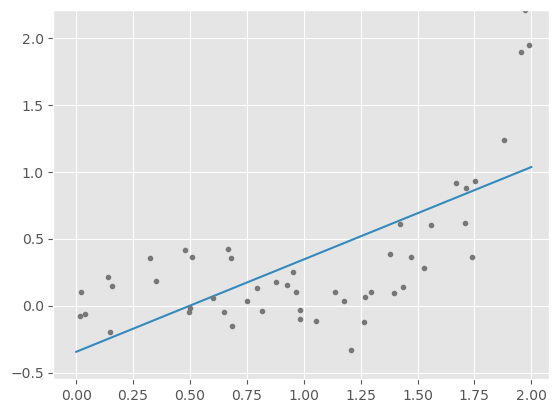

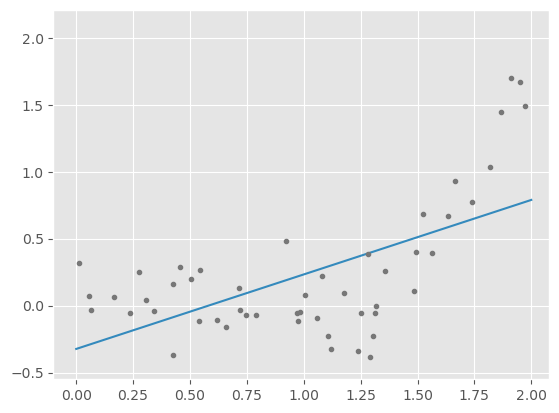

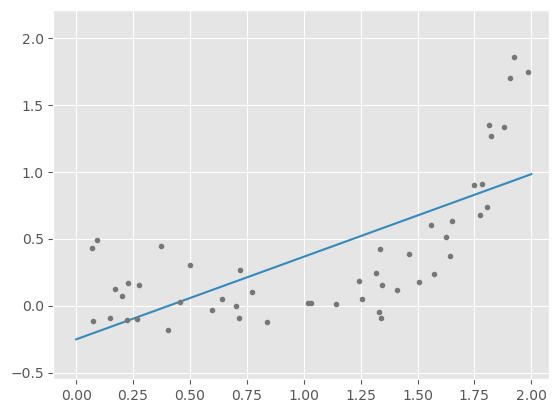

In [5]:
plot_predictions(X_all[0], y_all[0], LinearRegression())
plot_predictions(X_all[1], y_all[1], LinearRegression())
plot_predictions(X_all[2], y_all[2], LinearRegression())

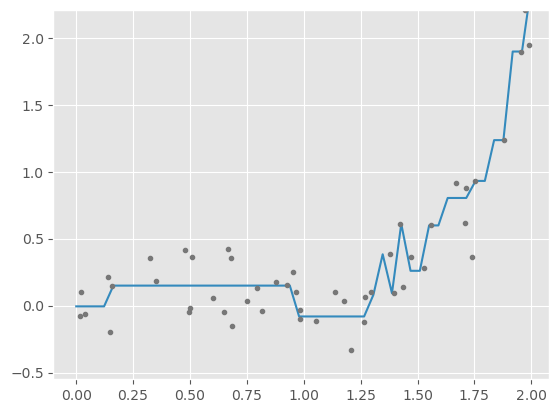

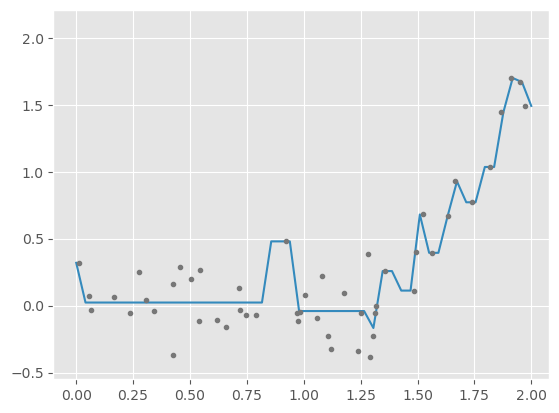

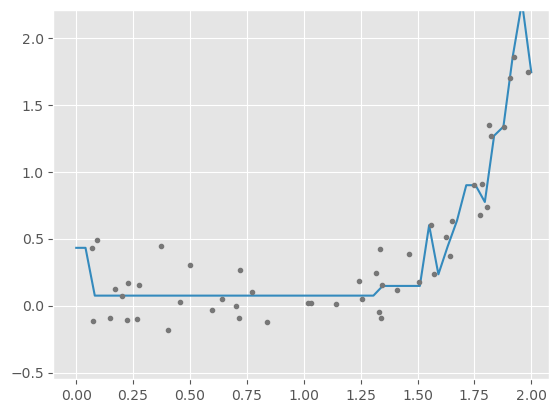

In [6]:
# выберем max_depth=5, иначе предсказания дерева пройдут через каждую точку
plot_predictions(X_all[0], y_all[0], DecisionTreeRegressor(max_depth=5))
plot_predictions(X_all[1], y_all[1], DecisionTreeRegressor(max_depth=5))
plot_predictions(X_all[2], y_all[2], DecisionTreeRegressor(max_depth=5))

Уже сейчас видно, что деревья точнее попадают, однако от датасета к датасету предсказания модели в отдельных точках могут меняться довольно сильно. Обучим по модели на каждом из наших датасетов и посмотрим, насколько успешно линейная регрессия и решающее дерево попадают в среднем:

In [7]:
def plot_average_model(
        X_all: np.array,
        y_all: np.array,
        model: RegressorMixin,
        draw_models: int
    ) -> tuple[np.array]:
    """Для каждого датасета из набора (X_all, y_all) обучает модель model,
    считает среднее предсказание в каждой точке.
    
    Отрисовывает среднее предсказание, draw_models случайных предсказаний,
    а также правильный ответ.

    Возвращает массив средних предсказаний preds_average и массив std
    предсказаний моделей в каждой точке preds_std."""
    preds_all = []

    for i in range(samples_cnt):
        X, y = X_all[i, :], y_all[i, :]
        model = model.fit(X.reshape(-1, 1), y)
        preds = model.predict(x_linspace.reshape(-1, 1))
        preds_all.append(preds)

    preds_all = np.array(preds_all)
    preds_average = np.mean(preds_all, axis=0)
    preds_std = np.std(preds_all, axis=0)

    draw_idx = np.random.choice(samples_cnt, size=draw_models, replace=False)

    plt.plot(x_linspace, y_linspace, label="y true")

    for idx in draw_idx:
        plt.plot(x_linspace, preds_all[idx, :], '-', color="C1")

    plt.plot(x_linspace, preds_average, "--", color="k", label="average of models")
    plt.xlim(-0.1, 2.08)
    plt.ylim(-0.55, 2.21)
    plt.legend()
    plt.title(model.__class__.__name__)
    plt.show()

    return preds_average, preds_std

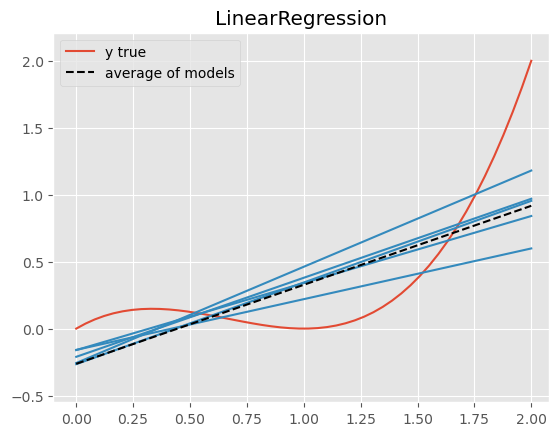

In [8]:
linreg_average, linreg_error_std = plot_average_model(X_all, y_all, model=LinearRegression(), draw_models=5)

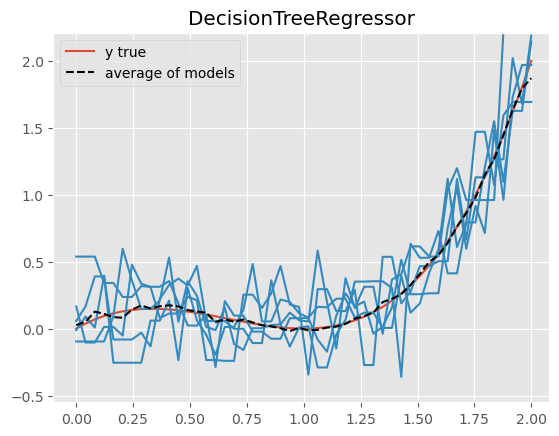

In [9]:
tree_average, tree_error_std = plot_average_model(X_all, y_all, model=DecisionTreeRegressor(), draw_models=5)

**Смещение** – насколько в среднем промахивается средняя модель относительно реальной зависимости (черная пунктирная линия относительно красной).

**Разброс** – насколько в среднем модели, обученные на разных выборках, имеют разные предсказания в одной точке (средняя дисперсия предсказаний в точке).

In [10]:
linreg_bias = np.mean( (linreg_average - y_linspace) ** 2 )
tree_bias = np.mean( (tree_average - y_linspace) ** 2 )

print(f"{linreg_bias = :.3f}")
print(f"{tree_bias = :.3f}")

linreg_bias = 0.123
tree_bias = 0.001


In [11]:
linreg_variance = np.mean(linreg_error_std)
tree_variance = np.mean(tree_error_std)

print(f"{linreg_variance = :.3f}")
print(f"{tree_variance = :.3f}")

linreg_variance = 0.084
tree_variance = 0.204
